In [32]:
%pip install keras
import keras
(x_train, y_train), (x_test, y_test) = keras.datasets.imdb.load_data(num_words=None)


print("Training entries: {}, labels: {}".format(len(x_train), len(y_train)))
print(x_train[0])
print(y_train[0])

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Training entries: 25000, labels: 25000
[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 22665, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 21631, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 19193, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 10311, 8, 4, 107, 117, 5952, 15, 256, 4, 31050, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 12118, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 3

In [ ]:
#count how many times xi shows up in x_train
from collections import Counter
word_counts = Counter()
for x in x_train:
    word_counts.update(x)
print(word_counts.most_common(10))

#1. Count how many times word xi shows up in positive reviews.
positive_word_counts = Counter()
negative_word_counts = Counter()
positive_review_word_count = 0
negative_review_word_count = 0

#2. Count the number of words in all positive reviews. If the same word shows up multiple times
#keep counting it again and again.
for i, x in enumerate(x_train):
    if y_train[i] == 1:
        positive_word_counts.update(x)
        positive_review_word_count += len(x)
    else:
        negative_word_counts.update(x)
        negative_review_word_count += len(x)

#3. Divide the result of step 1 by the result of step 2. This gives us ; an estimate for

word_positive_probs = {}
word_negative_probs = {}
for word, count in positive_word_counts.items():
    word_positive_probs[word] = count / positive_review_word_count
for word, count in negative_word_counts.items():
    word_negative_probs[word] = count / negative_review_word_count

#4. Repeat the process above for all words . And then repeat the same for the negative reviews
#to obtain 



word_sentiment_ratios = {}
for word in set(list(word_positive_probs.keys()) + list(word_negative_probs.keys())):
    positive_prob = word_positive_probs.get(word, 0)
    negative_prob = word_negative_probs.get(word, 0)
    if negative_prob == 0:
        word_sentiment_ratios[word] = float('inf')
    else:
        word_sentiment_ratios[word] = positive_prob / negative_prob
#Print the 10 words with highest sentiment ratios
#print what the actual word string is next to the ratio
word_index = keras.datasets.imdb.get_word_index()

inverse_word_index = {v: k for k, v in word_index.items()}
most_positive_words = sorted(word_sentiment_ratios.items(), key=lambda x: x[1], reverse=True)[:10]
#print one review that includes each of the most positive words
for word, ratio in most_positive_words:
    print(f"Word: {inverse_word_index.get(word - 3, '?')}, Ratio: {ratio}")
    for i, x in enumerate(x_train):
        if word in x and y_train[i] == 1:
            print("Review:", ' '.join([inverse_word_index.get(i - 3, '?') for i in x]))
            break
#Print the 10 words with lowest sentiment ratios
most_negative_words = sorted(word_sentiment_ratios.items(), key=lambda x: x[1])[:10]
#print what the actual word string is next to the ratio
for word, ratio in most_negative_words:
    print(f"Word: {inverse_word_index.get(word - 3, '?')}, Ratio: {ratio}")
    for i, x in enumerate(x_train):
        if word in x and y_train[i] == 0:
            print("Review:", ' '.join([inverse_word_index.get(i - 3, '?') for i in x]))
            break

import re
import math
import collections
#assume cntPos and cntNeg are already defined as Counters for positive and negative word
#counts respectively
#assume word_count_Pos and word_count_Neg are already defined as total word counts for
#positive and negative reviews respectively
#assume Voc is already defined as the vocabulary set
def laplace_smoothing(word, cntPos, cntNeg, word_count_Pos, word_count_Neg, Voc, alpha=1.0):
    V = len(Voc)
    prob_word_given_pos = (cntPos.get(word, 0) + alpha) / (word_count_Pos + alpha * V)
    prob_word_given_neg = (cntNeg.get(word, 0) + alpha) / (word_count_Neg + alpha * V)
    return prob_word_given_pos, prob_word_given_neg

#example usage
word = 100  # example word index to test
cntNeg = collections.Counter()
cntPos = collections.Counter()
prob_pos, prob_neg = laplace_smoothing(word, cntPos, cntNeg, positive_review_word_count,
                                        negative_review_word_count, set(word_counts.keys()), alpha=1.0
                                        )
print(f"Word: {inverse_word_index.get(word - 3, '?')}, P(word|pos): {prob_pos}, P(word|neg): {prob_neg}")


[(4, 336148), (5, 164097), (6, 163040), (7, 145847), (8, 135708), (9, 107313), (10, 101871), (11, 93934), (12, 79058), (13, 77142)]
Word: edie, Ratio: inf
Review: ? well easily my favourite tv series ever call me a walking mail cliché but include violence mafia sex gambling drugs etc on a show and you're already winning points on in my book combine all that with acting that superceeds anything you've ever seen on the small screen add directing that fits cinema of the vintage type and most of all writing that blows the mind and a few brains a long the way and you got yourself a show thats gonna be pretty tough to compete with br br above all stand two actors james gandolfini as tony soprano and edie falco as his wife carmela as for gandolfini he fits his roll in a way that words cannot express if you haven't seen him as tony yet see it now br br i can go on and on and on about every character in the show the psychological brilliance the gripping scenes etc but you wouldn't be able to st

In [ ]:
#build a word frequency table
word_freq_table = {}
for word, count in word_counts.items():
    positive_count = positive_word_counts.get(word, 0)
    negative_count = negative_word_counts.get(word, 0)
    word_freq_table[word] = {
        'total_count': count,
        'positive_count': positive_count,
        'negative_count': negative_count,
        'positive_prob': positive_count / positive_review_word_count,
        'negative_prob': negative_count / negative_review_word_count,
        'sentiment_ratio': word_sentiment_ratios[word]
    }
print(word_freq_table[1])  # Example: print frequency data for word with index 1

#display top 5 most common words with their sentiment ratios
#display the word string itself, its count, and its sentiment ratio
most_common_words = word_counts.most_common(5)
for word, count in most_common_words:
    ratio = word_sentiment_ratios[word]
    print(f"Word: {inverse_word_index.get(word - 3, '?')}, Count: {count}, Sentiment Ratio: {ratio}")



    

{'total_count': 25000, 'positive_count': 12500, 'negative_count': 12500, 'positive_prob': 0.0041397075114496034, 'negative_prob': 0.004239725618525091, 'sentiment_ratio': 0.9764092971869529}
Word: the, Count: 336148, Sentiment Ratio: 1.0352483134162649
Word: and, Count: 164097, Sentiment Ratio: 1.1778007708504696
Word: a, Count: 163040, Sentiment Ratio: 1.0292573335311945
Word: of, Count: 145847, Sentiment Ratio: 1.0875408277000063
Word: to, Count: 135708, Sentiment Ratio: 0.9447272765831745


In [21]:
#apply laplace just on the first 10 words
for word in list(word_counts.keys())[:10]:
    prob_pos, prob_neg = laplace_smoothing(word, cntPos, cntNeg, positive_review_word_count,
                                           negative_review_word_count, set(word_counts.keys()), alpha=1.0
                                           )
    print(f"Word: {inverse_word_index.get(word - 3, '?')}, P(word|pos): {prob_pos}, P(word|neg): {prob_neg}")
    

Word: ?, P(word|pos): 3.217376924071835e-07, P(word|neg): 3.292843432868307e-07
Word: this, P(word|pos): 3.217376924071835e-07, P(word|neg): 3.292843432868307e-07
Word: film, P(word|pos): 3.217376924071835e-07, P(word|neg): 3.292843432868307e-07
Word: was, P(word|pos): 3.217376924071835e-07, P(word|neg): 3.292843432868307e-07
Word: just, P(word|pos): 3.217376924071835e-07, P(word|neg): 3.292843432868307e-07
Word: brilliant, P(word|pos): 3.217376924071835e-07, P(word|neg): 3.292843432868307e-07
Word: casting, P(word|pos): 3.217376924071835e-07, P(word|neg): 3.292843432868307e-07
Word: location, P(word|pos): 3.217376924071835e-07, P(word|neg): 3.292843432868307e-07
Word: scenery, P(word|pos): 3.217376924071835e-07, P(word|neg): 3.292843432868307e-07
Word: story, P(word|pos): 3.217376924071835e-07, P(word|neg): 3.292843432868307e-07


In [28]:
#apply laplace smoothing to all words in the vocabulary and update their probabilities
for word in word_counts.keys():
    prob_pos, prob_neg = laplace_smoothing(word, positive_word_counts, negative_word_counts,
                                           positive_review_word_count, negative_review_word_count,
                                           set(word_counts.keys()), alpha=1.0)
    word_positive_probs[word] = prob_pos
    word_negative_probs[word] = prob_neg

print(word_positive_probs[1], word_negative_probs[1])  
# Example: print smoothed probabilities for word with index 1


0.004022042892782201 0.00411638357542867


In [ ]:
#replace word frequency table probabilities with smoothed probabilities
for word in word_freq_table.keys():
    prob_pos, prob_neg = laplace_smoothing(word, positive_word_counts, negative_word_counts,
                                           positive_review_word_count, negative_review_word_count,
                                           set(word_counts.keys()), alpha=1.0)
    word_freq_table[word]['positive_prob'] = prob_pos
    word_freq_table[word]['negative_prob'] = prob_neg

#compute smoothed sentiment ratios

alpha = 1.0
for word in set(list(word_positive_probs.keys()) + list(word_negative_probs.keys())):
    positive_prob = (positive_word_counts.get(word, 0) + alpha) / (positive_review_word_count + alpha * len(word_counts))
    negative_prob = (negative_word_counts.get(word, 0) + alpha) / (negative_review_word_count + alpha * len(word_counts))
    word_sentiment_ratios[word] = positive_prob / negative_prob

#train naive bayes classifier using the word frequency table

import numpy as np

class NaiveBayesClassifier:
    def __init__(self, word_freq_table, alpha=1.0):
        self.word_freq_table = word_freq_table
        self.alpha = alpha
        self.vocab_size = len(word_freq_table)
        self.total_positive_words = sum([data['positive_count'] for data in word_freq_table.values()])
        self.total_negative_words = sum([data['negative_count'] for data in word_freq_table.values()])
        self.prior_positive = 0.5  # Assuming equal prior probabilities
        self.prior_negative = 0.5

    def predict(self, review):
        log_prob_positive = np.log(self.prior_positive)
        log_prob_negative = np.log(self.prior_negative)
        for word in review:
            data = self.word_freq_table.get(word, None)
            if data:
                prob_word_given_positive = (data['positive_count'] + self.alpha) / (self.total_positive_words + self.alpha * self.vocab_size)
                prob_word_given_negative = (data['negative_count'] + self.alpha) / (self.total_negative_words + self.alpha * self.vocab_size)
            else:
                prob_word_given_positive = self.alpha / (self.total_positive_words + self.alpha * self.vocab_size)
                prob_word_given_negative = self.alpha / (self.total_negative_words + self.alpha * self.vocab_size)
            log_prob_positive += np.log(prob_word_given_positive)
            log_prob_negative += np.log(prob_word_given_negative)
        return 1 if log_prob_positive > log_prob_negative else 0
classifier = NaiveBayesClassifier(word_freq_table)
#evaluate classifier on test set
correct = 0
for i, x in enumerate(x_test):
    prediction = classifier.predict(x)
    if prediction == y_test[i]:
        correct += 1
accuracy = correct / len(x_test)
print(f"Accuracy: {accuracy}")
    

Accuracy: 0.81332



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


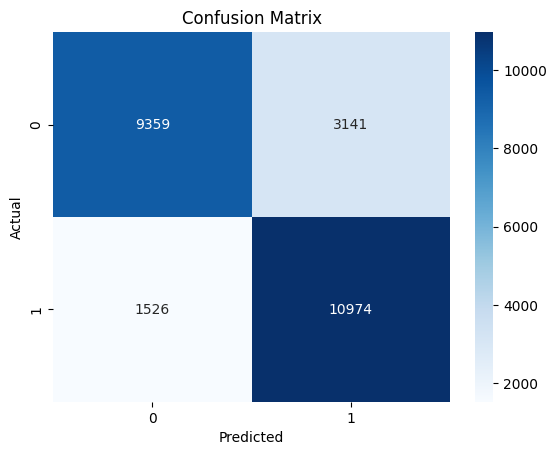

In [37]:
#plot confusion matrix
%pip install seaborn matplotlib scikit-learn
y_true = y_test
y_pred = [classifier.predict(x) for x in x_test]

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true, y_pred, labels=[1, 0])

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [31]:
#display 5 probably positive reviews and 5 probably negative reviews from the test set
positive_reviews_displayed = 0
negative_reviews_displayed = 0
for i, x in enumerate(x_test):
    prediction = classifier.predict(x)
    if prediction == 1 and positive_reviews_displayed < 5:
        print("Predicted Positive Review:", ' '.join([inverse_word_index.get(i - 3, '?') for i in x]))
        positive_reviews_displayed += 1
    elif prediction == 0 and negative_reviews_displayed < 5:
        print("Predicted Negative Review:", ' '.join([inverse_word_index.get(i - 3, '?') for i in x]))
        negative_reviews_displayed += 1
    if positive_reviews_displayed >= 5 and negative_reviews_displayed >= 5:
        break



Predicted Negative Review: ? please give this one a miss br br kristy swanson and the rest of the cast rendered terrible performances the show is flat flat flat br br i don't know how michael madison could have allowed this one on his plate he almost seemed to know this wasn't going to work out and his performance was quite lacklustre so all you madison fans give this a miss
Predicted Positive Review: ? this film requires a lot of patience because it focuses on mood and character development the plot is very simple and many of the scenes take place on the same set in frances austen's the sandy dennis character apartment but the film builds to a disturbing climax br br the characters create an atmosphere rife with sexual tension and psychological trickery it's very interesting that robert altman directed this considering the style and structure of his other films still the trademark altman audio style is evident here and there i think what really makes this film work is the brilliant pe

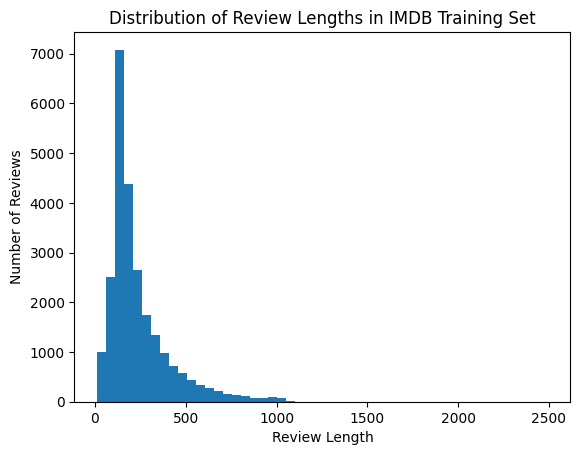

In [21]:
#Graph the distribution of review lengths in the training set
import matplotlib.pyplot as plt
review_lengths = [len(x) for x in x_train]
plt.hist(review_lengths, bins=50)
plt.xlabel('Review Length')
plt.ylabel('Number of Reviews')
plt.title('Distribution of Review Lengths in IMDB Training Set')
plt.show()


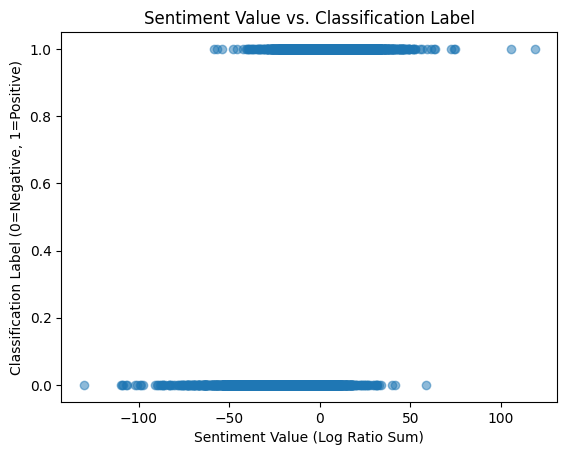

In [22]:
#plot sentiment value and classification label
import matplotlib.pyplot as plt

sentiment_values = []
for x in x_test:
    sentiment_score = 0
    for word in x:
        ratio = word_sentiment_ratios.get(word, 1.0)
        sentiment_score += np.log(ratio) if ratio > 0 else 0
    sentiment_values.append(sentiment_score)    
plt.scatter(sentiment_values, y_test, alpha=0.5)
plt.xlabel('Sentiment Value (Log Ratio Sum)')
plt.ylabel('Classification Label (0=Negative, 1=Positive)')
plt.title('Sentiment Value vs. Classification Label')
plt.show()

In [23]:
#display misclassified reviews
for i, x in enumerate(x_test):
    prediction = classifier.predict(x)
    if prediction != y_test[i]:
        print(f"Misclassified Review (Predicted: {prediction}, Actual: {y_test[i]}):", ' '.join([inverse_word_index.get(i - 3, '?') for i in x]))
        

Misclassified Review (Predicted: 0, Actual: 1): ? like some other people wrote i'm a die hard mario fan and i loved this game br br this game starts slightly boring but trust me it's worth it as soon as you start your hooked the levels are fun and exiting they will hook you 'till your mind turns to mush i'm not kidding this game is also orchestrated and is beautifully done br br to keep this spoiler free i have to keep my mouth shut about details but please try this game it'll be worth it br br story 9 9 action 10 1 it's that good hardness 10 attention grabber 10 average 10
Misclassified Review (Predicted: 0, Actual: 1): ? i'm absolutely disgusted this movie isn't being sold all who love this movie should email disney and increase the demand for it they'd eventually have to sell it then i'd buy copies for everybody i know everything and everybody in this movie did a good job and i haven't figured out why disney hasn't put this movie on dvd or on vhs in rental stores at least i haven't 

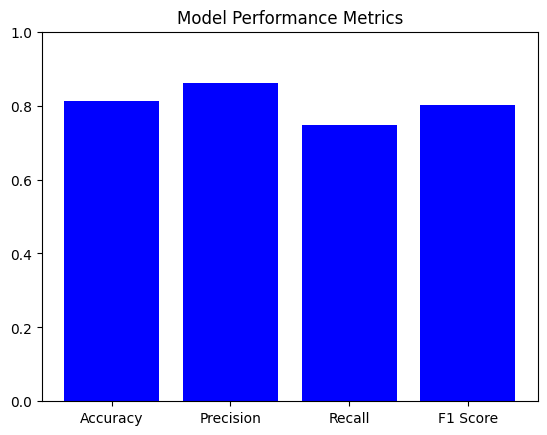

In [45]:
#plot accuracy, precision, recall, and F1 score
from sklearn.metrics import accuracy_score as acc, precision_score as prec, recall_score as rec, f1_score as f1

metrics = {
    'Accuracy': acc(y_true, y_pred),
    'Precision': prec(y_true, y_pred, pos_label=1),
    'Recall': rec(y_true, y_pred, pos_label=1),
    'F1 Score': f1(y_true, y_pred, pos_label=1)
}
plt.bar(metrics.keys(), metrics.values(), color='blue')
plt.title("Model Performance Metrics")
plt.ylim(0, 1)
plt.show()
